# Präsenzversuch zum Laval-Rotor

Name: Diogo Fernandes Costa  
Datum: 03.02.2024 
Gruppe: 37

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Wie können Eigenfrequenzen von Rotorprüfständen ermittelt und dargestellt werden? Inwieweit kann dies mit analytischen Berechnungen verglichen werden?

## Erster Versuch: Prüfstand 04
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

![pruefstand04.jpeg](pictures/pruefstand04.jpeg)

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:
Der Versuch ist wie folgt aufgebaut: Der Aufbau besteht aus einer Welle, die eine Länge von 75 Zentimeter und einen Durchmesser von 8 Millimetern aufweist. Auf dieser Welle ist eine 1000 Gramm schwere Scheibe gelagert, die einen Durchmesser von 99  und eine Breite von 15 Millimetern besitzt. Die Welle ist mittels zwei Pendelkugellagern an beiden Enden gelagert, wobei sich in der Mitte ein Fanglager befindet, welches die maximale Auslenkung der Welle befestigt. Ein Beschleunigungssensor ist am Lagerblock der Welle befestigt und misst hierbei die Schwingungen der Welle. 

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240115_141438_lavalrotor_37_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240115_141438_lavalrotor_37_04.h5"  # name of the H5-file
h5_path=os.path.join(path_measurement_folder,filename) 

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

# Öffnet der HDF5-Datei
file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

# Initialisiert leere Listen für die Beschleunigungsdaten in den drei Achsen, Zeitpunkte und Motor-Drehzahlen
accel_x = []
accel_y = []
accel_z = [] 
time = [] 
rpm = [] 

# Iteriert über alle Schlüssel (keys) in der HDF5-Datei
for i in range(len(file.keys())):
    # Überprüft, ob der aktuelle Index i mit einem Schlüssel übereinstimmt
    for key in file.keys():
        if str(i) == key:
            # Fügt die Beschleunigungsdaten, Zeitpunkte und Motor-Drehzahlen den entsprechenden Listen hinzu
            accel_x.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_x"]))
            accel_y.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_y"]))
            accel_z.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acceleration]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))
            


#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  # reload functions

# Initialisiert eine leere Liste für die absolute Beschleunigung
abs_accel = []

# Berechnet die absolute Beschleunigung für die Datenpunkte
for i in range(len(accel_x)):
    abs_accel.append(m_postprocessing.get_vec_accel(accel_x[i], accel_y[i], accel_z[i]))

# Initialisiert eine leere Liste für die interpolierten Daten
interp_data = []

# Führt eine Interpolation für die Datenpunkte durch
for i in range(len(accel_x)):
    interp_data.append(m_postprocessing.interpolation(time[i], abs_accel[i], interpolation_points))

# Initialisiert eine leere Liste für die FFT-Ergebnisse
fft_res = []

# Führt eine FFT für die interpolierten Daten der ersten 20 Datensätze durch
for i in range(len(accel_x)):
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], interpolation_points))

# Extrahiert die Frequenzdaten aus dem ersten FFT-Ergebnis
freq_ex = fft_res[0][1]

# Initialisiert eine leere Liste für die Amplituden der FFT-Ergebnisse
amp_res = []

# Extrahiert die Amplituden aus allen FFT-Ergebnissen und fügt sie der Liste hinzu
for i in fft_res:
    amp_res.append(i[0])
    
# Konvertiert die Liste der Amplituden in ein NumPy-Array
amp_res = np.array(amp_res)

# Transponiert das NumPy-Array der Amplituden
amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

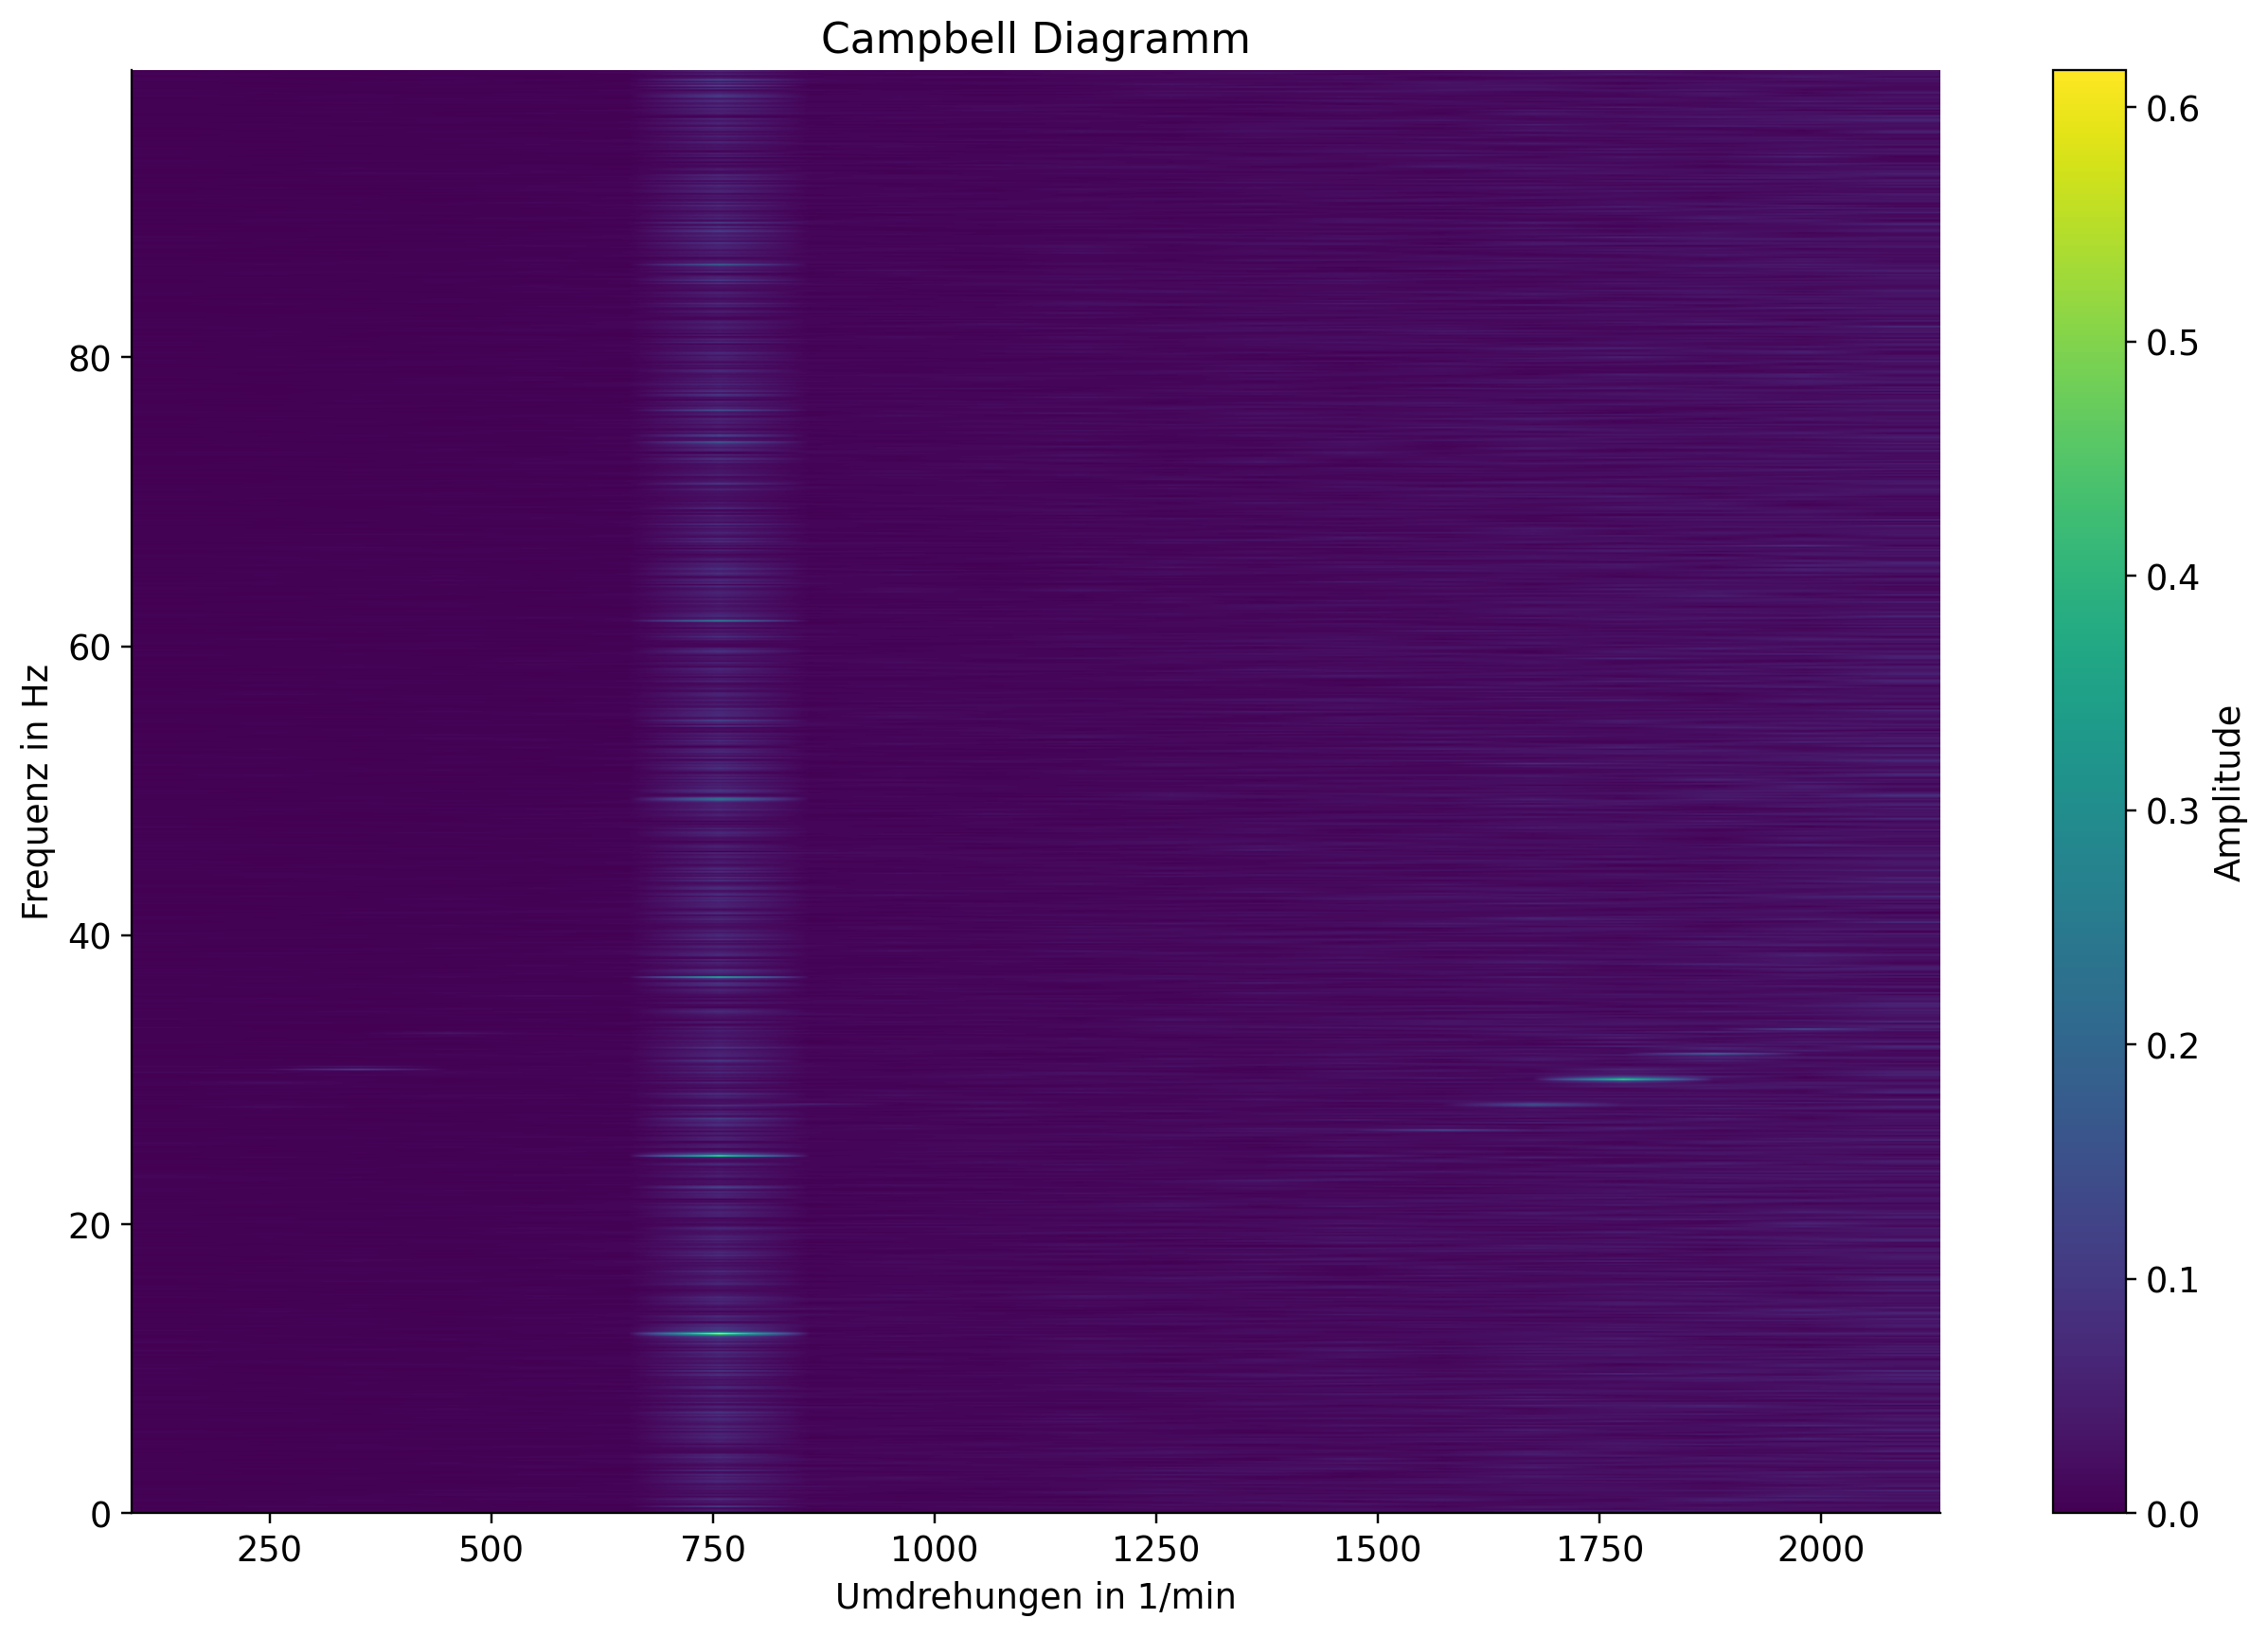

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

# Zeige das Bild (2D-Diagramm) mit den Daten der Amplituden an.
# Die 'extent'-Parameter geben die Achsengrenzen für x und y an.
# 'aspect="auto"' sorgt dafür, dass das Bild automatisch skaliert wird.
# 'interpolation="bilinear"' stellt die Interpolationsmethode für die Bilddarstellung ein.
# 'cmap="viridis"' wählt die Farbkarte für die Darstellung der Daten.
# 'origin="lower"' legt den Ursprung des Koordinatensystems unten links fest.

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="viridis",
           origin="lower"  
          )

#Beschriften des Campbell-Diagramms zur besseren Veranschaulichung
plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Zweiter Datensatz: Prüfstand #2

#### 1. Einlesen der Mess- und Metadaten

In [7]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file
h5_path=os.path.join(path_measurement_folder,filename)

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)  


# Öffnen der HDF5-Datei
file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

# Initialisiert leere Listen für die Beschleunigungsdaten in den drei Achsen, Zeitpunkte und Motor-Drehzahlen
accel_x = []
accel_y = []
accel_z = [] 
time = [] 
rpm = [] 

# Iteriert über alle Schlüssel (keys) in der HDF5-Datei
for i in range(len(file.keys())):
    # Überprüft, ob der aktuelle Index i mit einem Schlüssel übereinstimmt
    for key in file.keys():
        if str(i) == key:
            # Fügt die Beschleunigungsdaten, Zeitpunkte und Motor-Drehzahlen den entsprechenden Listen hinzu
            accel_x.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_x"]))
            accel_y.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_y"]))
            accel_z.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acceleration]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))


{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [8]:
importlib.reload(m_postprocessing)  # reload functions

# Initialisiert eine leere Liste für die absolute Beschleunigung
abs_accel = []

# Berechnet die absolute Beschleunigung für die Datenpunkte
for i in range(len(accel_x)):
    abs_accel.append(m_postprocessing.get_vec_accel(accel_x[i], accel_y[i], accel_z[i]))

# Initialisiert eine leere Liste für die interpolierten Daten
interp_data = []

# Führt eine Interpolation für die Datenpunkte durch
for i in range(len(accel_x)):
    interp_data.append(m_postprocessing.interpolation(time[i], abs_accel[i], interpolation_points))

# Initialisiert eine leere Liste für die FFT-Ergebnisse
fft_res = []

# Führt eine FFT für die interpolierten Daten der ersten 20 Datensätze durch
for i in range(len(accel_x)):
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], interpolation_points))

# Extrahiert die Frequenzdaten aus dem ersten FFT-Ergebnis
freq_ex = fft_res[0][1]

# Initialisiert eine leere Liste für die Amplituden der FFT-Ergebnisse
amp_res = []

# Extrahiert die Amplituden aus allen FFT-Ergebnissen und fügt sie der Liste hinzu
for i in fft_res:
    amp_res.append(i[0])
    
# Konvertiert die Liste der Amplituden in ein NumPy-Array
amp_res = np.array(amp_res)

# Transponiert das NumPy-Array der Amplituden
amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

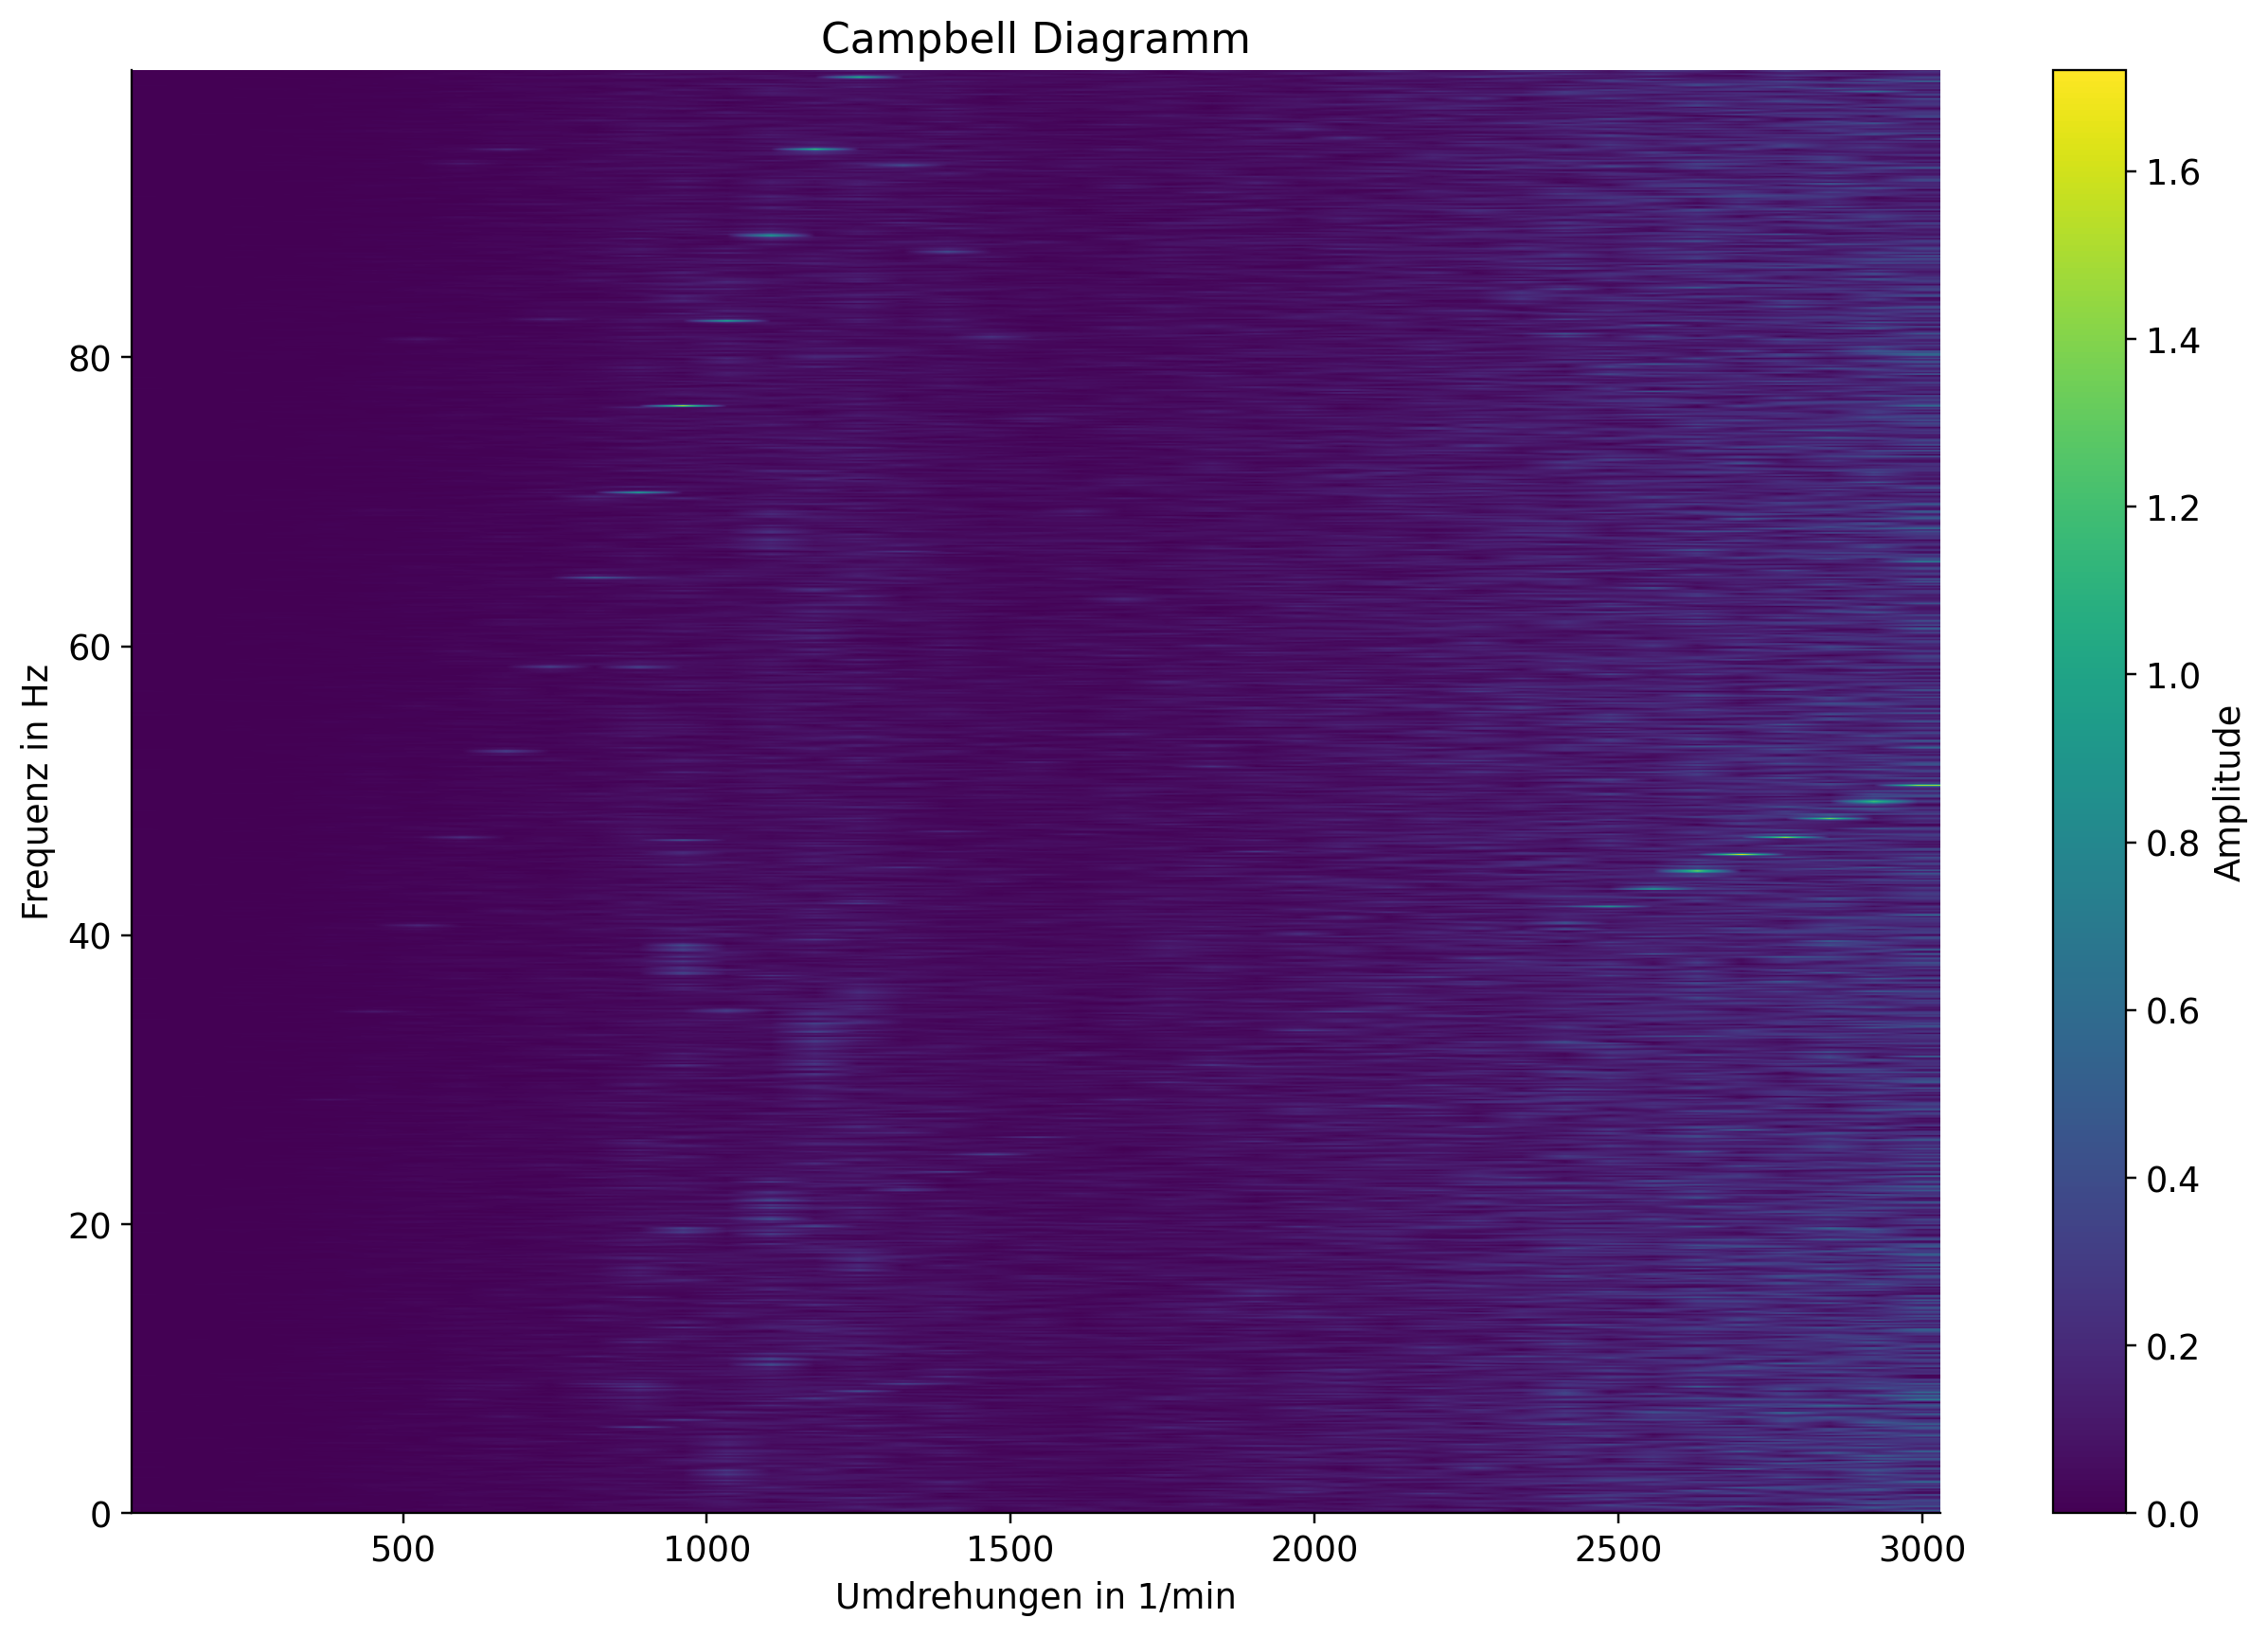

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

# Zeige das Bild (2D-Diagramm) mit den Daten der Amplituden an.
# Die 'extent'-Parameter geben die Achsengrenzen für x und y an.
# 'aspect="auto"' sorgt dafür, dass das Bild automatisch skaliert wird.
# 'interpolation="bilinear"' stellt die Interpolationsmethode für die Bilddarstellung ein.
# 'cmap="viridis"' wählt die Farbkarte für die Darstellung der Daten.
# 'origin="lower"' legt den Ursprung des Koordinatensystems unten links fest.

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="viridis",
           origin="lower"  
          )

#Beschriften des Campbell-Diagramms zur besseren Veranschaulichung
plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Dritter Datensatz: Prüfstand 03

#### 1. Einlesen der Mess- und Metadaten

In [10]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file
h5_path=os.path.join(path_measurement_folder,filename)

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)


# Öffnen der HDF5-Datei
file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

# Initialisiert leere Listen für die Beschleunigungsdaten in den drei Achsen, Zeitpunkte und Motor-Drehzahlen
accel_x = []
accel_y = []
accel_z = [] 
time = [] 
rpm = [] 

# Iteriert über alle Schlüssel (keys) in der HDF5-Datei
for i in range(len(file.keys())):
    # Überprüft, ob der aktuelle Index i mit einem Schlüssel übereinstimmt
    for key in file.keys():
        if str(i) == key:
            # Fügt die Beschleunigungsdaten, Zeitpunkte und Motor-Drehzahlen den entsprechenden Listen hinzu
            accel_x.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_x"]))
            accel_y.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_y"]))
            accel_z.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acceleration]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))


{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [11]:
importlib.reload(m_postprocessing)  # reload functions

# Initialisiert eine leere Liste für die absolute Beschleunigung
abs_accel = []

# Berechnet die absolute Beschleunigung für die Datenpunkte
for i in range(len(accel_x)):
    abs_accel.append(m_postprocessing.get_vec_accel(accel_x[i], accel_y[i], accel_z[i]))

# Initialisiert eine leere Liste für die interpolierten Daten
interp_data = []

# Führt eine Interpolation für die Datenpunkte durch
for i in range(len(accel_x)):
    interp_data.append(m_postprocessing.interpolation(time[i], abs_accel[i], interpolation_points))

# Initialisiert eine leere Liste für die FFT-Ergebnisse
fft_res = []

# Führt eine FFT für die interpolierten Daten der ersten 20 Datensätze durch
for i in range(len(accel_x)):
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], interpolation_points))

# Extrahiert die Frequenzdaten aus dem ersten FFT-Ergebnis
freq_ex = fft_res[0][1]

# Initialisiert eine leere Liste für die Amplituden der FFT-Ergebnisse
amp_res = []

# Extrahiert die Amplituden aus allen FFT-Ergebnissen und fügt sie der Liste hinzu
for i in fft_res:
    amp_res.append(i[0])
    
# Konvertiert die Liste der Amplituden in ein NumPy-Array
amp_res = np.array(amp_res)

# Transponiert das NumPy-Array der Amplituden
amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

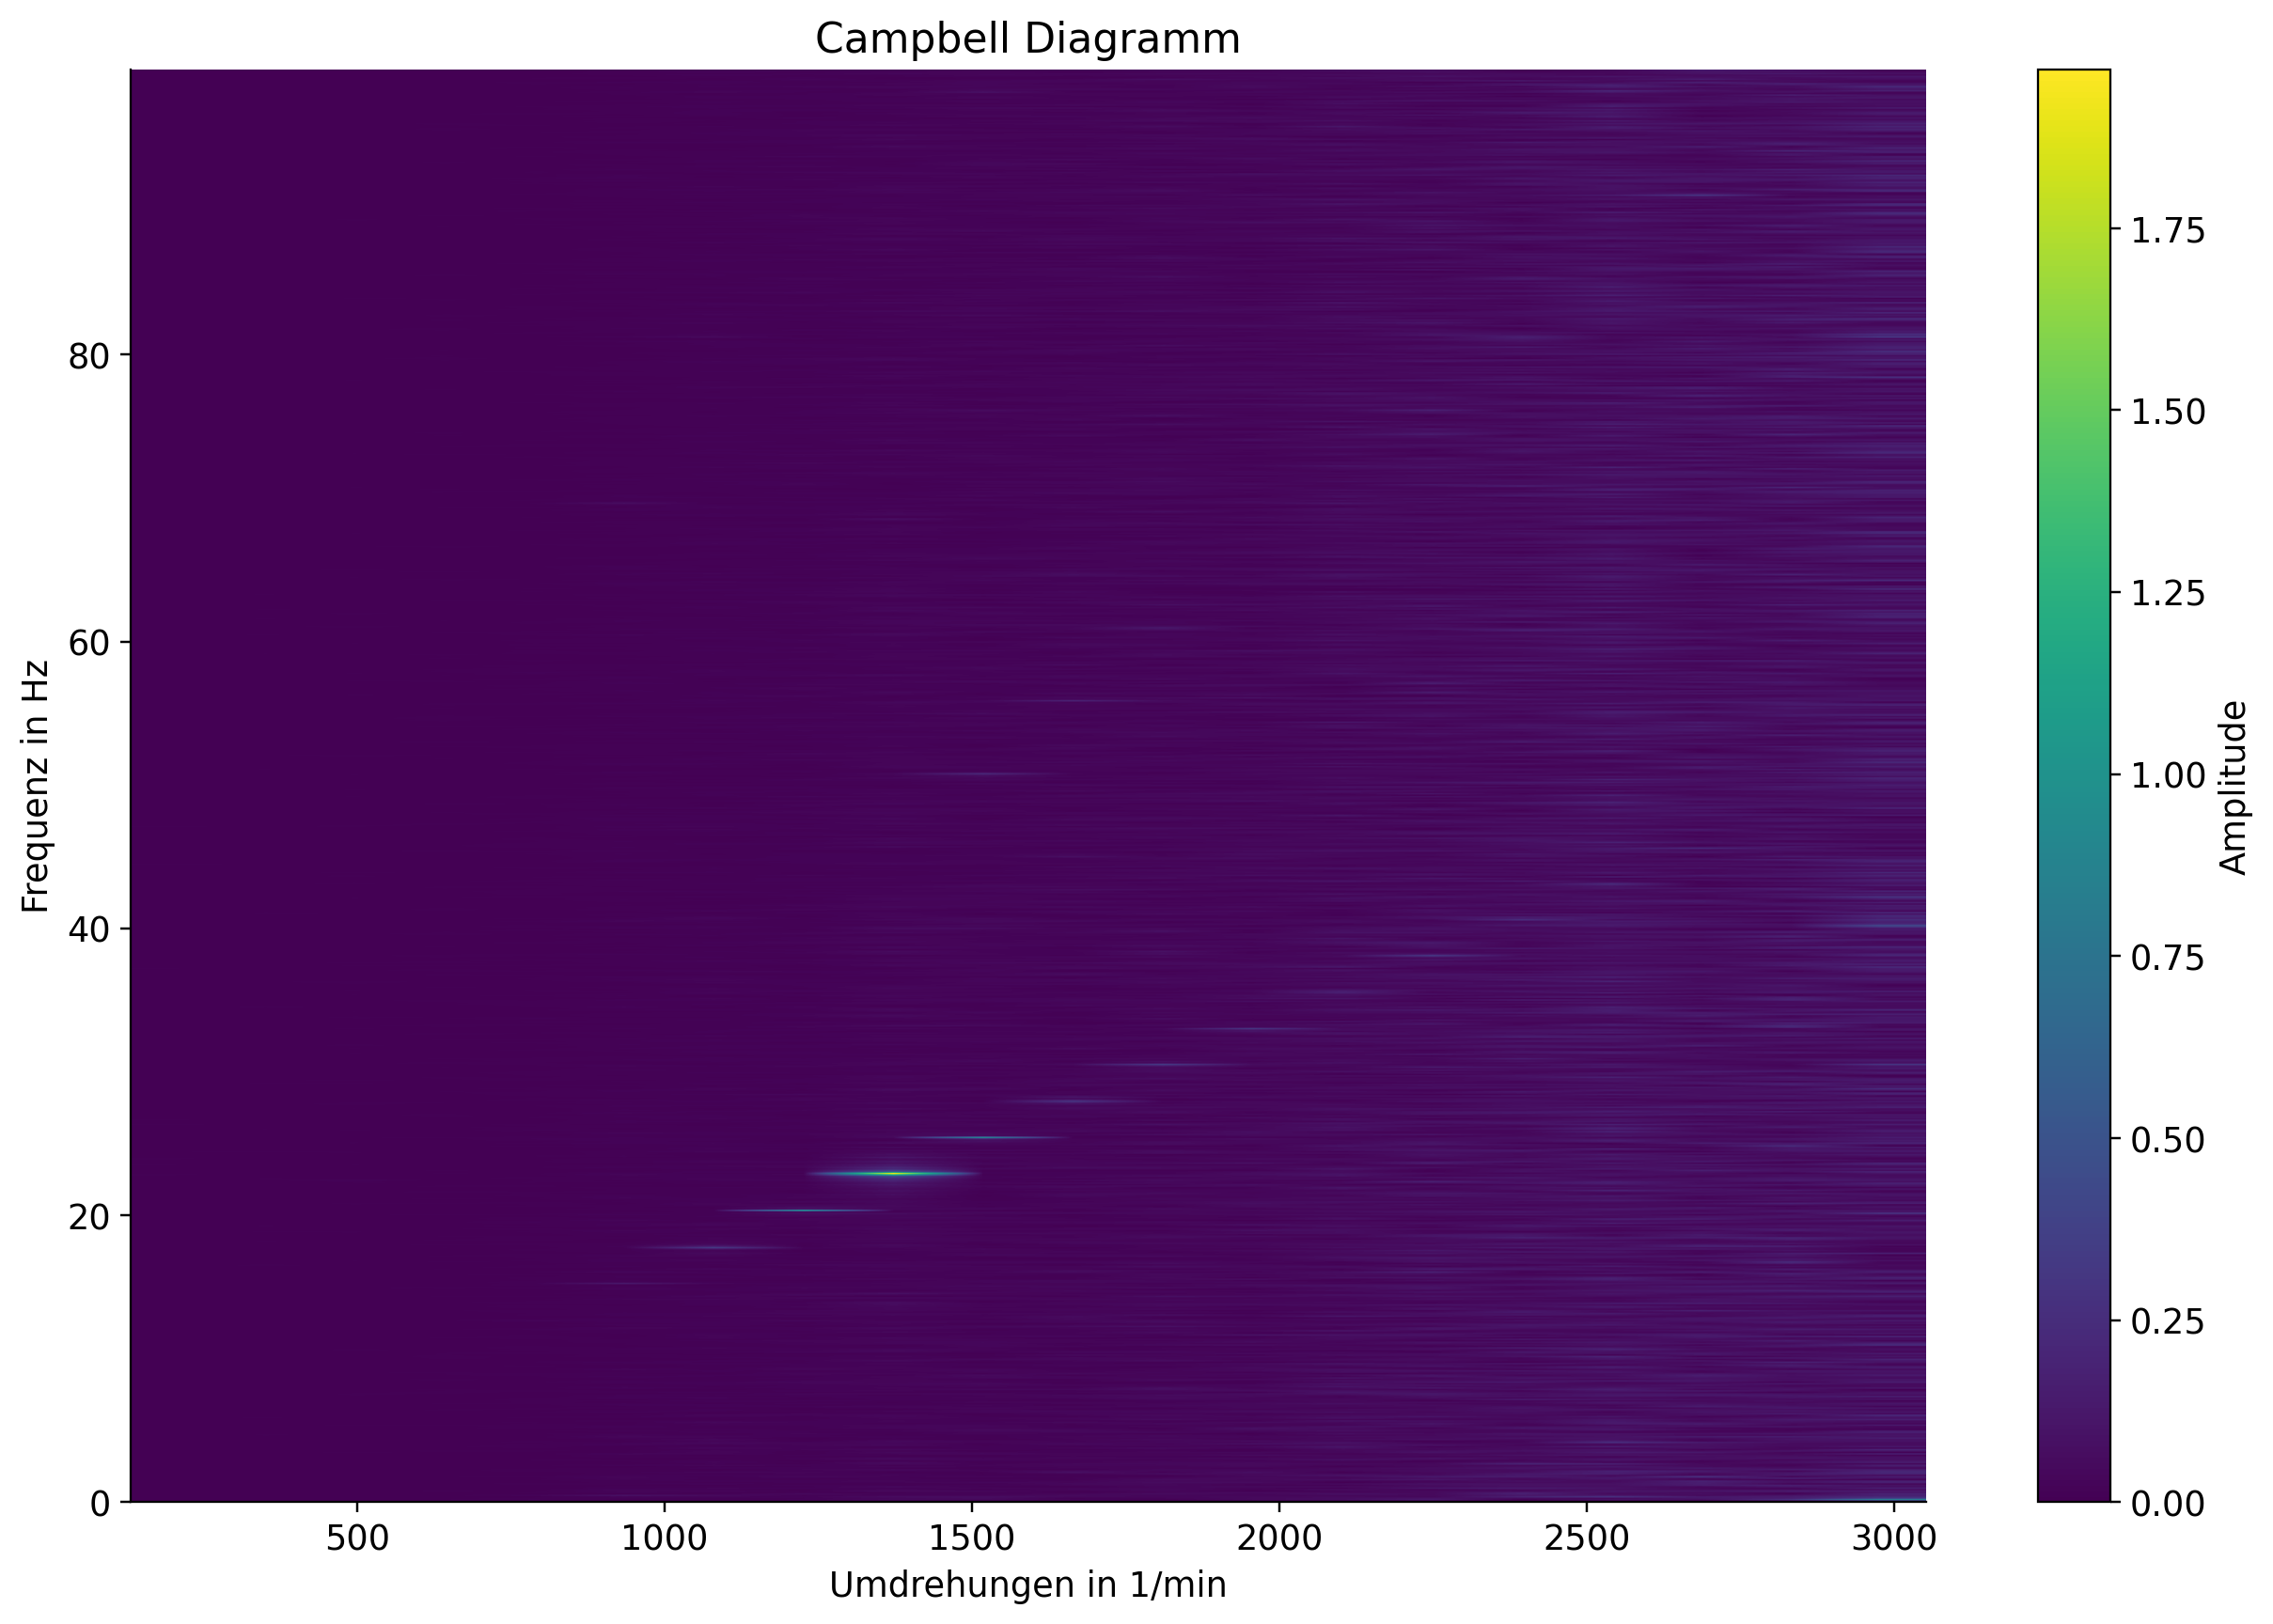

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

# Zeige das Bild (2D-Diagramm) mit den Daten der Amplituden an.
# Die 'extent'-Parameter geben die Achsengrenzen für x und y an.
# 'aspect="auto"' sorgt dafür, dass das Bild automatisch skaliert wird.
# 'interpolation="bilinear"' stellt die Interpolationsmethode für die Bilddarstellung ein.
# 'cmap="viridis"' wählt die Farbkarte für die Darstellung der Daten.
# 'origin="lower"' legt den Ursprung des Koordinatensystems unten links fest.

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="viridis",
           origin="lower"  
          )

#Beschriften des Campbell-Diagramms zur besseren Veranschaulichung
plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Kritische Drehzahl des vierten Prüfstandes

$$
\omega_{krit} = 750 \frac{U}{min}
$$
mit einem relativ großen Nebenmaximum bei 

$$
\omega \thickapprox 1750 \frac{U}{min},
$$

was auf eine relativ schlechte rotordynamische Stabilität hindeutet, da die analytische Berechnung auf nur eine existierende kritische Drehzahl hinweist.

Kritische Drehzahlen des zweiten Prüfstandes liegen bei ca.

$$
\omega_{krit,1} = 1000 \frac{U}{min}, \omega_{krit,2} = 2600 \frac{U}{min},
$$

was plausibel erscheint, dass diese kritischen Drehzahlen größer sind als die des Vierten, da die beiden Scheiben eine geringere Masse aufweisen und die Winkelgeschwindigkeit proportional zu 1/sqrt(m) ist.

Dennoch sind auch hier an dem Campbell-Diagramm einige Nebenmaxima zu erkennen, was ebenfalls auf eine eher instabile Rotordynamik hindeutet.

Kritische Drehzahl des dritten Prüfstandes liegt bei ca.

$$
\omega_{krit} = 1500 \frac{U}{min},
$$

wobei einige Nebenmaxima auftauchen, jedoch deutlich begrenzter als in den anderen Datensätzen. Hier ist die rotordynamische Stabilität deutlich besser und die Amplitude lässt sich eindeutig abgrenzen. Auch wenn insgesamt die Stabilität nicht optimal war, lassen sich in den Datensätzen des vierten Prüfstandes und dritten Prüfstandes eindeutige Amplituden aus den Diagrammen ablesen. Die Datensätze des vierten und zweiten Prüfstandes führen, ohne weiteres Hintergrundwissen über den Versuchsaufbau, zu einem verfälschten Ergebnis, da die Diagramme relativ große Nebenmaxima aufweisen, die auf weitere Drehzahlen hindeuten, obwohl nur eine (Prüfstand 4) bzw. zwei (Prüfstand 2) existieren.Prinzipiell lassen sich die Selbstzentrierungen durch die abnehmenden Amplituden (erkennbar an der dunkler werdenden Farbe) nach Durchfahren der kritischen Drehzahl(en) der Rotoren erkennen.


##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

![Berechnung_krit_Drehzahl.jpeg](pictures/Berechnung_krit_Drehzahl.jpeg)



Wie der Rechnung zu entnehmen ist, liegt die ablesbare kritische Drehzahl (750 U/min) unseres Prüfstandes im Bereich der errechneten, was auf eine zuverlässige Messung deutet, wenn man das oben genannte Nebenmaximum vernachlässigt.


## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Das Experiment war im Großen und Ganzen erfolgreich, da die approximierte kritische Drehzahl aus den händischen Berechnungen in der Nähe der gemessenen und analysierten kritischen Drehzahl von unserem Prüfstand liegt. Hierbei gibt es dennoch eine Abweichung von ca. 90 Umdrehungen pro Minute, was schlussendlich auf Vereinfachungen und Annahmen zu führen ist, die in der analytischen Berechnung getroffen wurden. Hierbei wurden die gegebenen Formeln der Aufgabenstellung verwendet, die nur einen kleinen Einblick in das Thema der Schwingungsanalyse zeigen. Ich konnte dazu mein Verständnis für die Analyse von Daten aus Schwingungsphänomen vertiefen und fand das Experiment äußerst interessant. Ich konnte einen Einblick in das Arbeiten mit einem Campbell-Diagramm erhalten und somit auch erschließen, wie man mögliche Resonanzfälle anschaulich darstellt und erkennt.